In [9]:
# INFT6201 Big Data 
# Trimester 3 2022
# Assignment 3
    
# Contributors:     Suyog Belbase c3341354,
#                   Deepa Bhattarai c3417299,
#                   Julia-Rose Brown c3194432, 
#                   Matthew Griffiths c3365589,
#                   Anton Komala c3384823 
# Date:             12-11-2022
# Description:      Perform analysis on the US Traffic Dataset including exploration of the dataset, statistical analysis
#                   predictive modelling of the Severity variable
# Package Versions: Python 3.9.13, Jupyter Notebooks 6.4.12, Scipy 1.9.3, Matplotlib 3.5.3, Imblearn 0.9.1,
#                   Seaborn 0.12.0, Sci-kit learn 1.1.3

# Data preparation

In [10]:
# Import libraries
# Basic libraries
import pandas as pd 
import numpy as np
from scipy import stats

# Visualisation libraries
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap 
import seaborn as sns

# Modelling libraries
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from matplotlib_venn import venn2_unweighted

# Set styles and display options
pd.options.display.precision = 4

In [11]:
# Functions
def farenheit_to_celsius(farenheit):
  return ((farenheit - 32) * (5/9))

def m_to_km(m):
  return (m*1.609344)

def in_to_mm(i):
  return (i*25.4)

# Function to retrieve performance metrics
def scores(name, y_test, y_pred):
        list = [name,
                precision_score(y_test, y_pred, average='weighted'),
                recall_score(y_test, y_pred, average='weighted'),
                f1_score(y_test, y_pred, average='weighted'),
                accuracy_score(y_test, y_pred)]
        return list

In [12]:
# Load data
df = pd.read_csv('ny_accidents.csv')

# Drop columns that won't be used in the analysis
try: # remove exception handling before submission
  cols = ['Unnamed: 0','Number', 'Airport_Code', 'Timezone', 'Country', 'State', 'Civil_Twilight','Nautical_Twilight','Astronomical_Twilight','Turning_Loop']
  df.drop(cols, axis=1, inplace=True)
except:
  pass

df.drop_duplicates() # Drop duplicates
df.dropna(inplace = True) # Drop rows with na values

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36779 entries, 0 to 39536
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 36779 non-null  object 
 1   Severity           36779 non-null  int64  
 2   Start_Time         36779 non-null  object 
 3   End_Time           36779 non-null  object 
 4   Start_Lat          36779 non-null  float64
 5   Start_Lng          36779 non-null  float64
 6   End_Lat            36779 non-null  float64
 7   End_Lng            36779 non-null  float64
 8   Distance.mi.       36779 non-null  float64
 9   Description        36779 non-null  object 
 10  Street             36779 non-null  object 
 11  Side               36779 non-null  object 
 12  City               36779 non-null  object 
 13  County             36779 non-null  object 
 14  Zipcode            36779 non-null  object 
 15  Weather_Timestamp  36779 non-null  object 
 16  Temperature.F.     367

In [13]:
# Pre-process of data
# Rename columns 
df.rename(columns = {'Distance.mi.':'Distance',
                     'Wind_Speed.mph.':'Wind_Speed',
                     'Temperature.F.':'Temperature',
                     'Wind_Chill.F.':'Wind_Chill',
                     'Humidity...':'Humidity',
                     'Pressure.in.':'Pressure',
                     'Visibility.mi.':'Visibility',
                     'Precipitation.in.':'Precipitation'}, inplace=True)

## Variable groups as lists
weather = ['Temperature', 'Humidity', 'Pressure','Visibility','Wind_Direction','Wind_Speed','Precipitation','Weather_Condition']
poi = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']

# Convert dates & times to datetime type
cols = ['Start_Time','End_Time','Weather_Timestamp']
df[cols] = df[cols].apply(pd.to_datetime, errors='coerce')

# Convert imperial units to metric
df[['Temperature', 'Wind_Chill']] = df[['Temperature', 'Wind_Chill']].apply(farenheit_to_celsius) # farenheit to celsius
df[['Visibility', 'Wind_Speed']] = df[['Visibility', 'Wind_Speed']].apply(m_to_km) # miles to kilometres
df['Precipitation'] = df['Precipitation'].apply(in_to_mm) # inches to mm

# Add severity_cat column
conditions  = [ df['Severity'] == 1, df['Severity'] == 2, df['Severity'] == 3, df['Severity'] == 4 ]
choices     = [ 'Low','Medium','High','Very High']
df['severitycat'] = np.select(conditions, choices, default=np.nan)

# Add highway column
keywords = ['Pkwy', 'Parkway', 'I-', 'Interstate', 'Expy', 'Exp', 'Expressway', 'Route', 'State', 'NY', 'Trwy', 'Throughway', 'US', 'Hwy', 'Highway', 'Wyck', '9n']
df['Highway'] = False #where False = other
df.loc[df['Street'].str.contains('|'.join(keywords), case = False) == True, 'Highway'] = True #where True = Highway

# Add weather_cat column to consolidate weather conditions
conditions = [df['Weather_Condition'].str.contains('Clear|Fair', case=False) == True,
              df['Weather_Condition'].str.contains('Cloud|Overcast', case=False) == True,
              df['Weather_Condition'].str.contains('Rain|Storm', case=False) == True,
              df['Weather_Condition'].str.contains('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms', case=False) == True,
              df['Weather_Condition'].str.contains('Snow|Sleet|Ice', case=False) == True,
              df['Weather_Condition'].str.contains('Heavy Snow|Heavy Sleet|Heavy Ice Pellets|Snow Showers|Squalls', case=False) == True,
              df['Weather_Condition'].str.contains('Fog', case=False) == True]
choices = ['Clear', 'Cloud', 'Rain', 'Heavy_rain', 'Snow', 'Heavy_Snow','Fog']
df['Weather_Condition'] = np.select(conditions, choices, default='Other') # Assign null value as clear

# Clean wind direction
df['Wind_Direction'].replace({'North':'N','West':'W','East':'E','Variable':'VAR','South':'S'}, inplace=True)

# Add weekday
df['Weekday'] = df['Start_Time'].dt.dayofweek

# Add month
df['Month'] = df['Start_Time'].dt.month

# Add year
df['Year'] = df['Start_Time'].dt.year

# Add season category
conditions = (df.Month < 3, df.Month < 5, df.Month < 8, df.Month <12, df.Month == 12)
choices = ['winter', 'spring','summer', 'fall', 'winter']
df['Season'] = np.select(conditions, choices, default=np.nan)

# Add incident duration
df['Duration'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds().div(60).astype(int)

## Add Traffic_Calming_ex_Bump
df['Traffic_Calming_ex_Bump'] = df['Traffic_Calming']
df['Traffic_Calming_ex_Bump'] = np.where(df.Bump == True, False, df['Traffic_Calming_ex_Bump'])

## Add Any_poi (collapsed poi)
df['Any_poi'] = df[poi].any(axis=1)

# Exploring Descriptive Variables

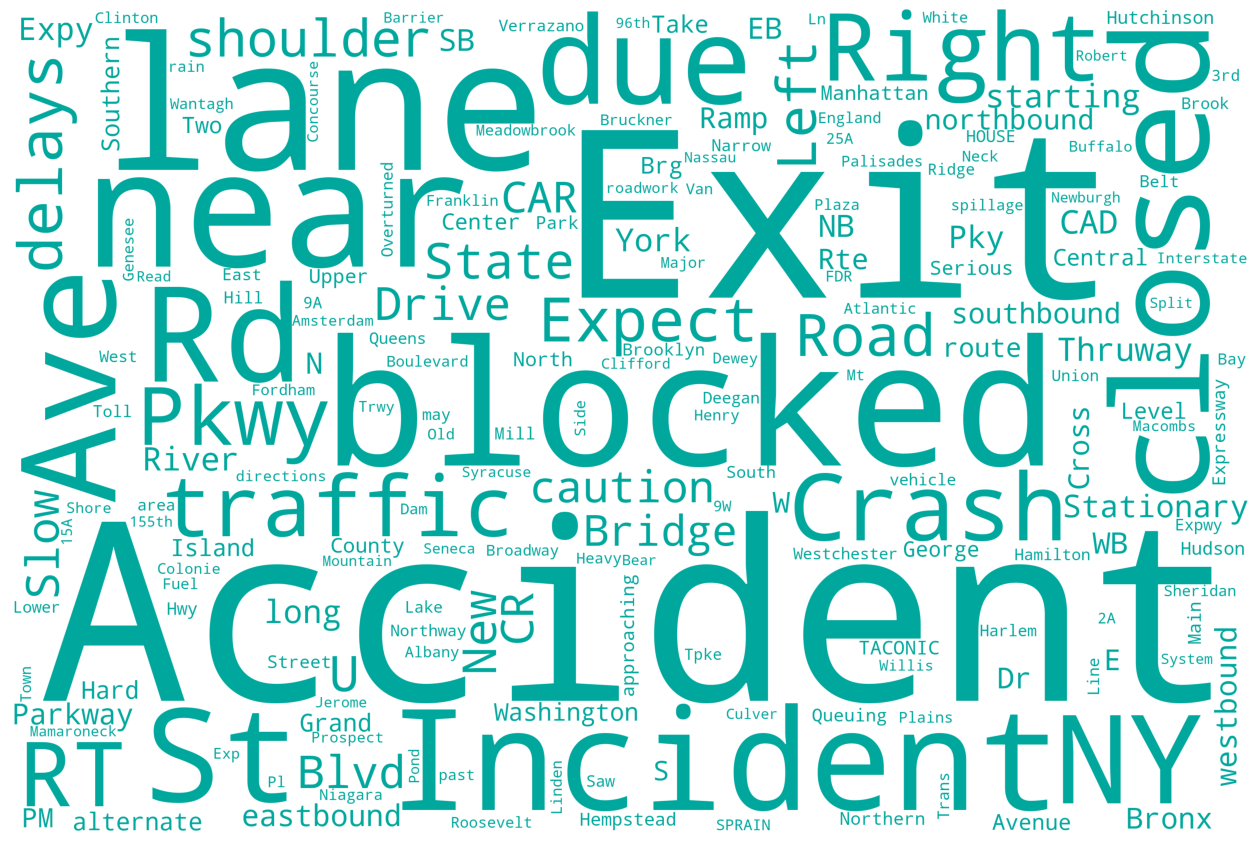

In [14]:
# Incident Description and Severity
# Visualise common terms in description of incident
from wordcloud import WordCloud, STOPWORDS
descriptors = list(df['Description'])
text = " ".join(descriptors)

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1,
    background_color='white', colormap='Set1', collocations=False, stopwords = STOPWORDS, color_func=lambda *args, **kwargs: "#00a79d").generate(text)
plt.figure(figsize=(16, 20))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

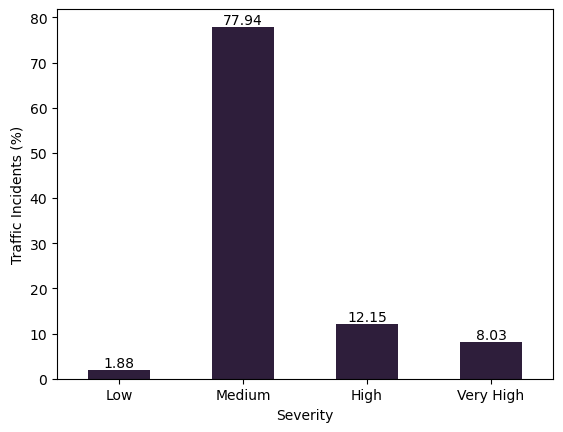

In [15]:
# Severity
# Plot percentage of severity by category
severity_prop = pd.DataFrame()
severity_prop['count'] = df['Severity'].groupby(df['Severity']).count()
severity_prop['percent'] = (severity_prop['count'] / severity_prop['count'].sum())*100

ax = severity_prop['percent'].plot(kind='bar', xlabel='Severity', ylabel='Traffic Incidents (%)', rot= colormap=ListedColormap(sns.color_palette('mako')))
for container in ax.containers:
    ax.bar_label(container, fmt= "%.2f")
ax.set_xticklabels(['Low','Medium','High','Very High'])
plt.show()

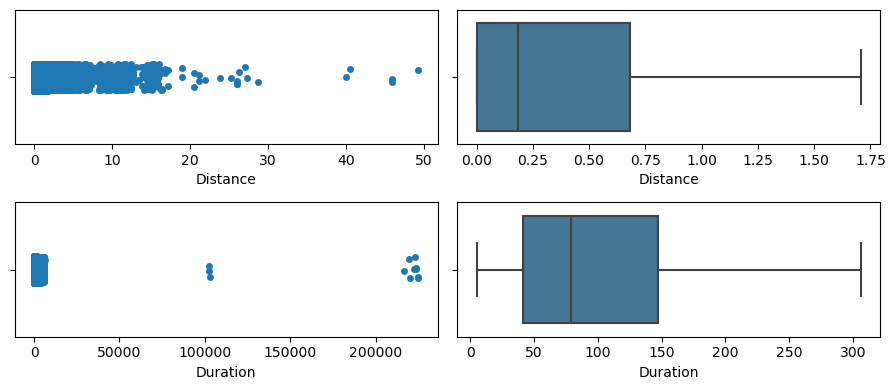

In [16]:
# Distance and Duration
# Explore Distance variable
fig, ax = plt.subplots(2, 2)
fig.set_figheight(4)
fig.set_figwidth(9)
sns.stripplot(ax = ax[0], x='Distance', data=df)
sns.boxplot(ax = ax[1], x='Distance', data=df, palette='mako', showfliers=False)
sns.stripplot(ax = ax[1,0], x='Duration', data=df)
sns.boxplot(ax = ax[1,1], x='Duration', data=df, palette='mako', showfliers=False)
fig.tight_layout()

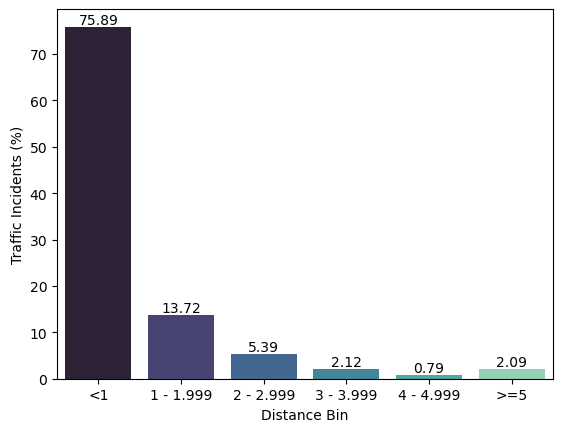

In [17]:
# Create df to organise distance to bins
distance_prop = pd.cut(df['Distance'],
             bins=[ 1, 2, 3, 4, 5, np.inf],
             labels=['<1','1 - 1.999','2 - 2.999', '3 - 3.999', '4 - 4.999', '>=5']).reset_index().groupby('Distance').count()
distance_prop = pd.DataFrame(distance_prop.reset_index().values)
distance_prop.set_axis(['distance_bin','count'], axis=1, inplace=True)
distance_prop['percent'] = distance_prop['count'].apply(lambda x: x / distance_prop['count'].sum() * 100)

# Visualise distance_bins
ax = sns.barplot(x='distance_bin', y='percent', data=distance_prop, palette = 'mako')
ax.set(title='', xlabel="Distance Bin", ylabel="Traffic Incidents (%)")
for container in ax.containers:
    ax.bar_label(container, fmt= "%.2f")
plt.show()

In [18]:
# Summarise distance and duration
pd.options.display.float_format = '{:,.2f}'.format # display 2 decimal points
num_dd = ['Distance','Duration'] # weather columns containing numerical variables
df_dd = df[num_dd].describe().T
df_dd = pd.concat([df_dd, df[num_dd].skew()], axis=1).rename(columns={0:'Skewness'})
df_dd = pd.concat([df_dd, df[num_dd].kurt()], axis=1).rename(columns={0:'Kurtosis'})
display(df_dd)

,count,mean,std,min,25%,50%,75%,max,Skewness,Kurtosis
Distance,"36,779.00",0.65,1.57,0.00,0.00,0.19,0.68,49.24,8.66,136.20
Duration,"36,779.00",219.11,"3,607.50",5.00,41.00,79.00,147.00,"224,923.00",58.80,"3,552.67"


In [19]:
# Weather variables
# Summarise weather data
pd.options.display.float_format = '{:,.2f}'.format # display 2 decimal points
num_weather = ['Temperature', 'Wind_Chill', 'Humidity', 'Pressure', 'Wind_Speed','Precipitation'] # weather columns containing numerical variables
df_weather_stats = df[num_weather].describe().T
df_weather_stats = pd.concat([df_weather_stats, df[num_weather].skew()], axis=1).rename(columns={0:'Skewness'})
df_weather_stats = pd.concat([df_weather_stats, df[num_weather].kurt()], axis=1).rename(columns={0:'Kurtosis'})
display(df_weather_stats)

,count,mean,std,min,25%,50%,75%,max,Skewness,Kurtosis
Temperature,"36,779.00",11.41,9.18,-24.44,4.44,11.11,18.33,35.56,0.03,-0.54
Wind_Chill,"36,779.00",10.00,10.71,-34.67,1.67,11.11,18.33,35.56,-0.15,-0.68
Humidity,"36,779.00",66.18,20.53,13.00,50.00,68.00,84.00,100.00,-0.22,-1.00
Pressure,"36,779.00",29.69,0.39,27.55,29.45,29.72,29.97,30.71,-0.73,1.51
Wind_Speed,"36,779.00",14.60,9.43,0.00,8.05,12.87,20.92,64.37,0.68,0.74
Precipitation,"36,779.00",0.13,0.70,0.00,0.00,0.00,0.00,21.08,10.24,149.76


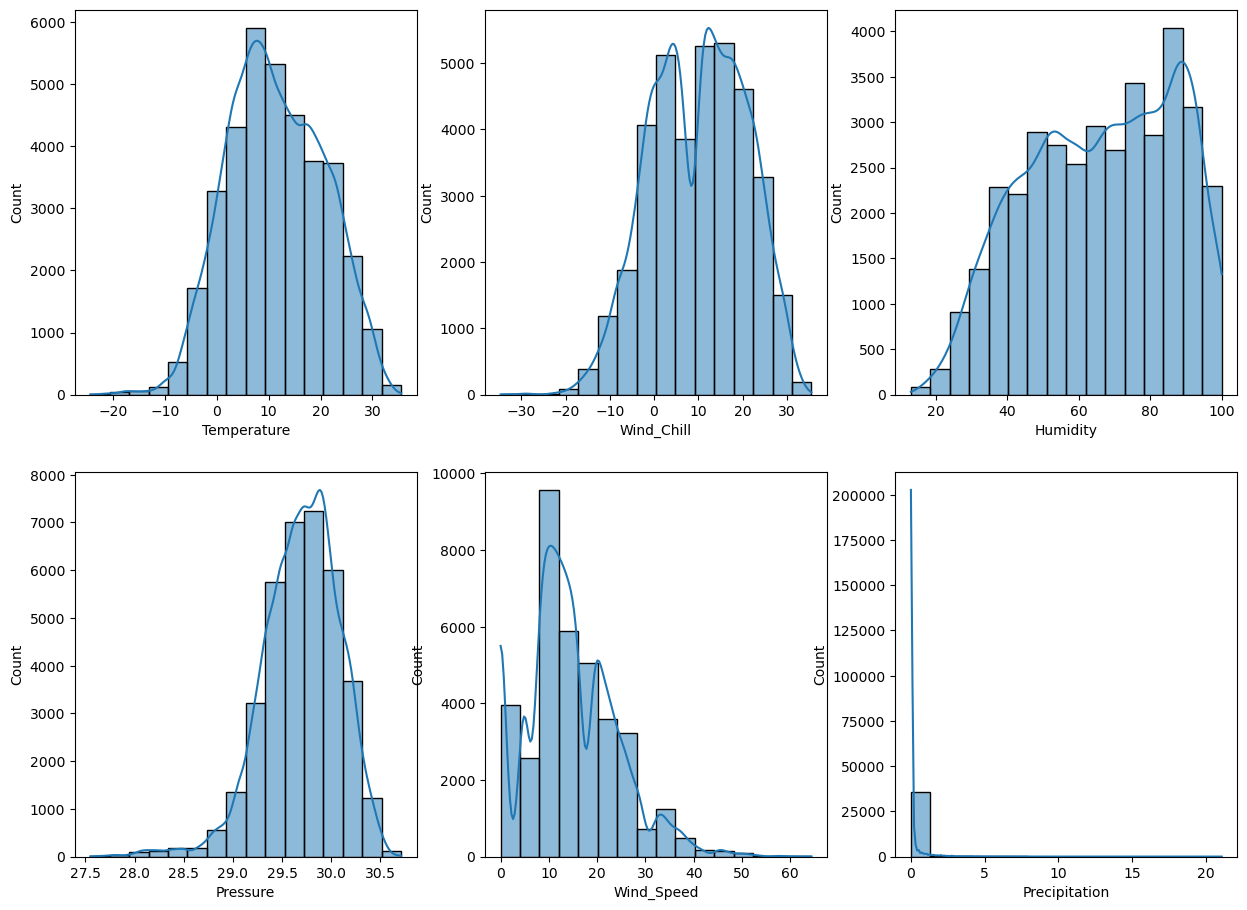

In [20]:
# Plot distribution of weather data
fig, ax = plt.subplots(2, 3)
fig.set_figheight(11)
fig.set_figwidth(15)
sns.histplot(ax = ax[0, 0], x='Temperature', data=df, kde=True, bins=16)
sns.histplot(ax = ax[0, 1], x='Wind_Chill', data=df, kde=True, bins=16)
sns.histplot(ax = ax[0, 2], x='Humidity', data=df, kde=True, bins=16)
sns.histplot(ax = ax[1, 0], x='Pressure', data=df, kde=True, bins=16)
sns.histplot(ax = ax[1, 1], x='Wind_Speed', data=df, kde=True, bins=16)
sns.histplot(ax = ax[1, 2], x='Precipitation', data=df, kde=True, bins=16)
#fig.delaxes(ax[1][2])
plt.show()

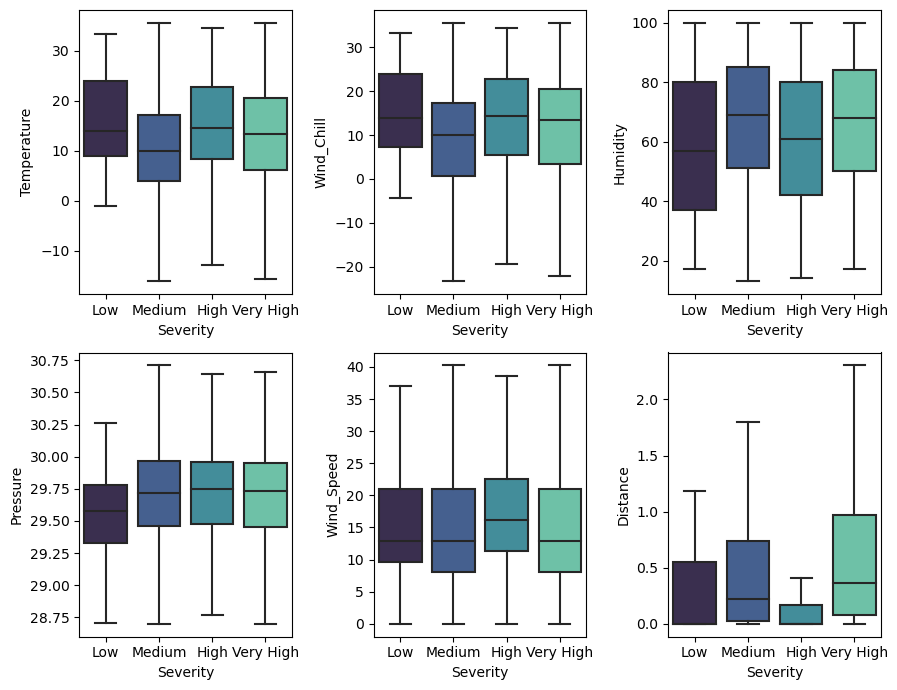

In [21]:
# Boxplot each weather variable
fig, ax = plt.subplots(2, 3)
fig.set_figheight(7)
fig.set_figwidth(9)
sns.boxplot(ax = ax[0, 0], x='Severity',y='Temperature', data=df, palette='mako', showfliers=False)
sns.boxplot(ax=ax[0, 1], x='Severity',y='Wind_Chill', data=df, palette='mako', showfliers=False)
sns.boxplot(ax= ax[0, 2], x='Severity',y='Humidity', data=df, palette='mako', showfliers=False)
sns.boxplot(ax = ax[1, 0], x='Severity',y='Pressure', data=df, palette='mako', showfliers=False)
sns.boxplot(ax = ax[1, 1], x='Severity',y='Wind_Speed', data=df, palette='mako', showfliers=False)
sns.boxplot(ax = ax[1, 2], x='Severity',y='Distance', data=df, palette='mako', showfliers=False)
plt.setp(ax, xticks=[0, 1, 2, 3], xticklabels=['Low', 'Medium', 'High', 'Very High'])
fig.tight_layout()

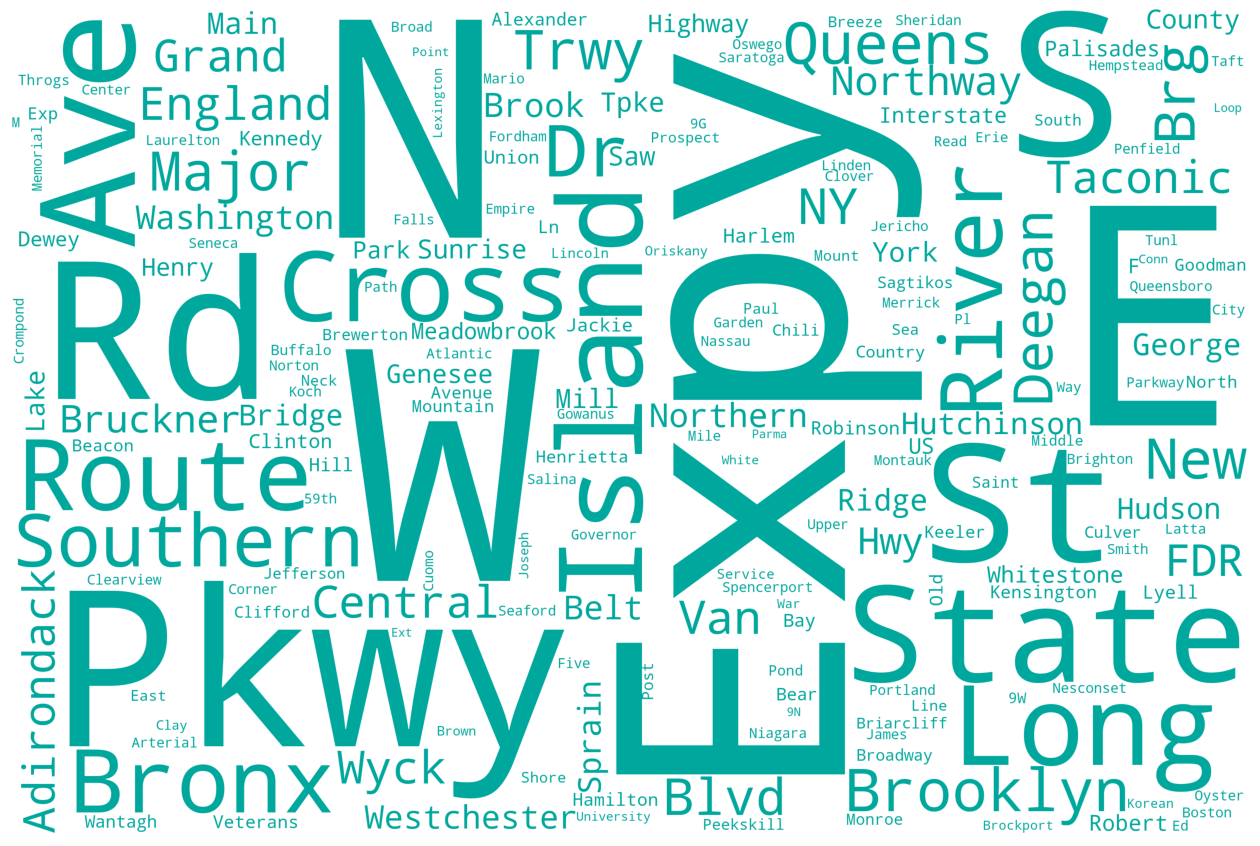

In [22]:
# Road type
# Visualise common terms in description of incident
from wordcloud import WordCloud, STOPWORDS
descriptors = list(df['Street'])
text = " ".join(descriptors)

wordcloud = WordCloud(width = 3000, height = 2000, random_state=1,
    background_color='white', colormap='Set1', collocations=False, stopwords = STOPWORDS, color_func=lambda *args, **kwargs: "#00a79d").generate(text)
plt.figure(figsize=(16, 20))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [23]:
# Add Street Type column to remove abbreviations of streets
conditions = [df['Street'].str.contains('Ave|Avenue', case = False) == True, 
              df['Street'].str.contains('St|Street', case = False) == True,
              df['Street'].str.contains('Rd|Road', case = False) == True,
              df['Street'].str.contains('Blvd|Boulevard', case = False) == True,
              df['Street'].str.contains('Pkwy|Parkway', case = False) == True,
              df['Street'].str.contains('Dr|Drive', case = False) == True,
              df['Street'].str.contains('I-|Interstate', case = False) == True,
              df['Street'].str.contains('Expy|Exp|Expressway', case = False) == True,
              df['Street'].str.contains('Route', case = False) == True,
              df['Street'].str.contains('State', case = False) == True,
              df['Street'].str.contains('NY', case = False) == True,
              df['Street'].str.contains('Trwy|Throughway', case = False) == True,
              df['Street'].str.contains('US', case = False) == True,
              df['Street'].str.contains('Hwy|Highway|Wyck|9n', case = False) == True, 
              df['Street'].str.contains('Loop', case = False) == True,
              df['Street'].str.contains('Bridge|Brg', case = False) == True, 
              df['Street'].str.contains('Cross', case = False) == True,
              df['Street'].str.contains('Ext|Exit', case = False) == True,
              df['Street'].str.contains('Broadway', case = False) == True,
              df['Street'].str.contains('Place|Pl', case = False) == True,
              df['Street'].str.contains('Bay|Shore', case = False) == True,
              df['Street'].str.contains('city|main|way|line', case = False) == True,]
choices = ['Ave', 'St', 'Rd', 'Blvd', 'Parkway', 'Dr', 'Interstate Highway', 'ExpressWay', 'Route', 'State', 'NY Highway', 'ThroughWay', 'US highway', 'Highway', 'Loop', 'Bridge', 'Cross', 'Exit', 'Broadway' ,'Place', 'Bay/shore', 'Random']
df['street_type'] = np.select(conditions, choices, default=np.nan)
df.groupby(['street_type'])['street_type'].count() # Count of stret types

street_type
Ave                   2885
Blvd                   687
Bridge                 906
Cross                    1
Dr                     966
Exit                     1
ExpressWay            5905
Highway                452
Interstate Highway    6771
Loop                    12
NY Highway             703
Parkway               3400
Place                   60
Random                 603
Rd                    4079
Route                  824
St                    7023
ThroughWay             857
US highway             121
nan                    523
Name: street_type, dtype: int64

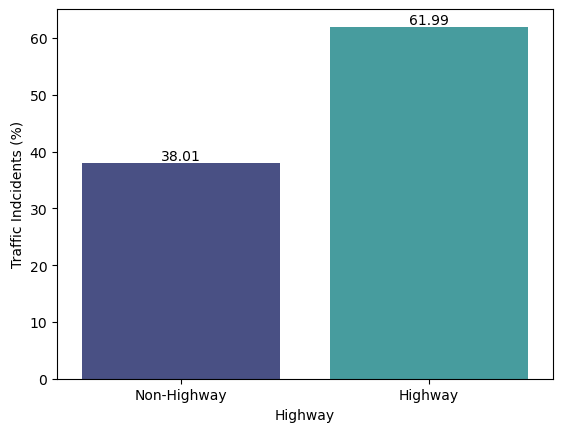

In [24]:
# Accident by Road Type
ax = sns.barplot(x='Highway', y='Severity', data=df, estimator=lambda x: len(x) / len(df) * 100 , palette = 'mako')
ax.set(title='', xlabel="Highway", ylabel="Traffic Indcidents (%)")
ax.set_xticklabels(['Non-Highway','Highway'])
for container in ax.containers:
    ax.bar_label(container, fmt= "%.2f")
plt.show()

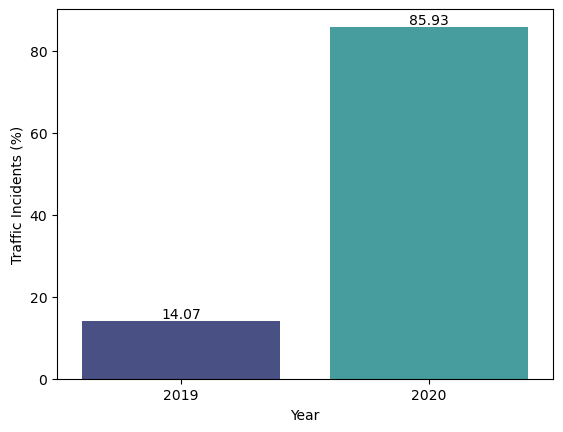

In [25]:
# Accidents and Time
# Accident Severity Counts by Year
ax = sns.barplot(x='Year', y='Year', data=df, estimator=lambda x: len(x) / len(df) * 100 , palette = 'mako')
ax.set(title='', xlabel="Year", ylabel="Traffic Incidents (%)")
for container in ax.containers:
    ax.bar_label(container, fmt= "%.2f")
plt.show()

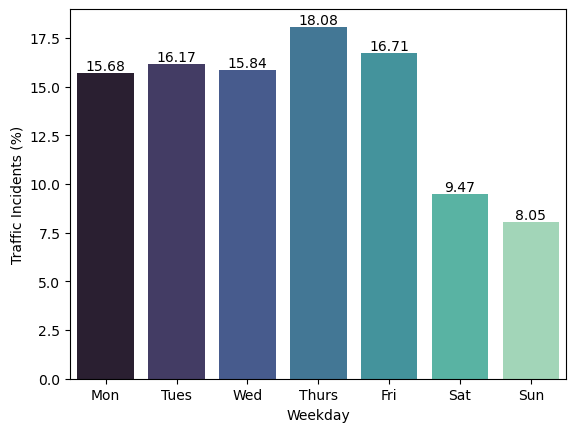

In [26]:
# Accident Severity Counts by Day of Week
ax = sns.barplot(x='Weekday', y='Weekday', data=df, estimator=lambda x: len(x) / len(df) * 100, palette = 'mako')
ax.set(title='', xlabel = "Weekday", ylabel="Traffic Incidents (%)")
ax.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs','Fri','Sat','Sun'])
for container in ax.containers:
    ax.bar_label(container, fmt= "%.2f")
plt.show()

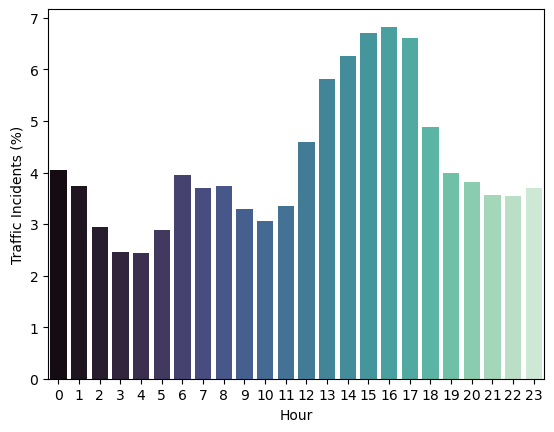

In [27]:
# Number of accidents per hour
ax = sns.barplot(x=df['Start_Time'].dt.hour, y='Severity', data=df, estimator=lambda x: len(x) / len(df) * 100 , palette = 'mako')
ax.set(title='', xlabel="Hour", ylabel="Traffic Incidents (%)")
plt.show()

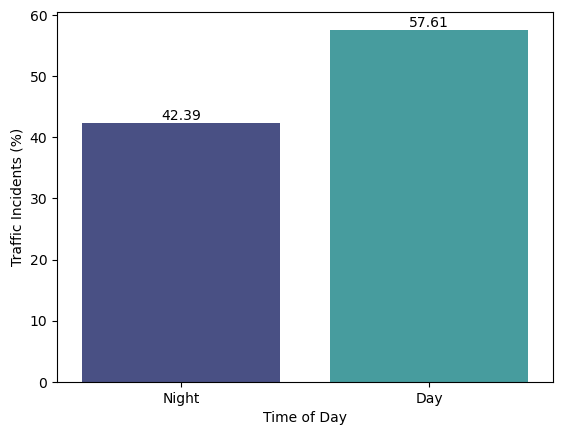

In [28]:
# Accident Severity Counts by Day/Night
ax = sns.barplot(x='Sunrise_Sunset', y='Severity', data=df, estimator=lambda x: len(x) / len(df) * 100 , palette = 'mako')
ax.set(title='', xlabel="Time of Day", ylabel="Traffic Incidents (%)")
for container in ax.containers:
    ax.bar_label(container, fmt= "%.2f")
plt.show()

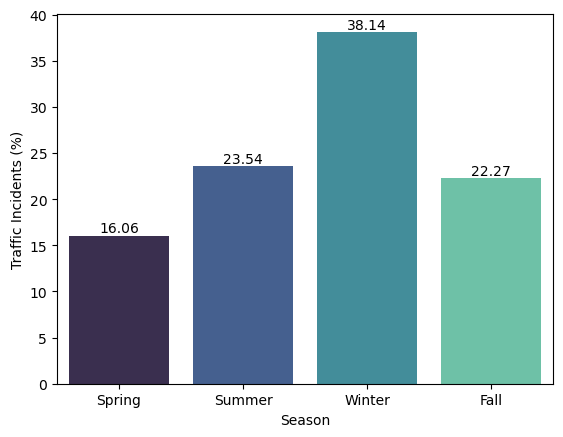

In [29]:
# Accident Severity Counts by Season
ax = sns.barplot(x='Season', y='Severity', order = ['spring','summer','fall','winter'], estimator=lambda x: len(x) / len(df) * 100, data=df,  palette = 'mako')
ax.set(title='', xlabel = "Season", ylabel="Traffic Incidents (%)")
ax.set_xticklabels(['Spring','Summer', 'Winter', 'Fall'])
for container in ax.containers:
    ax.bar_label(container, fmt= "%.2f")
plt.show()

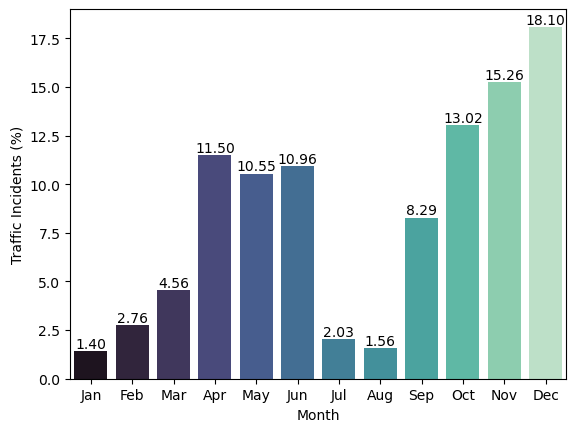

In [30]:
# Accident Severity Counts by Month
ax = sns.barplot(x='Month', y='Month', data=df, estimator=lambda x: len(x) / len(df) * 100 , palette = 'mako')
ax.set(title='', xlabel="Month", ylabel="Traffic Incidents (%)")
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
for container in ax.containers:
    ax.bar_label(container, fmt= "%.2f")
plt.show()

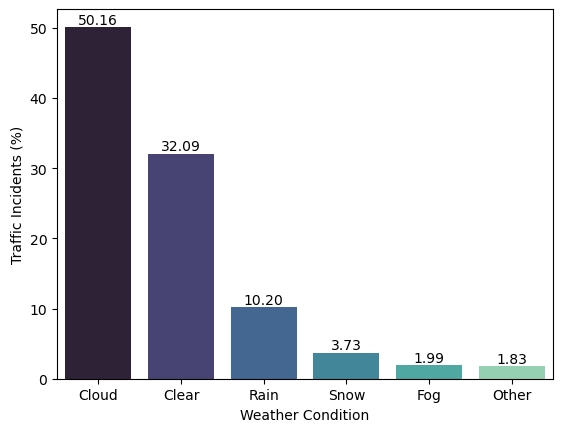

In [31]:
# Accident Severity Counts by Weather Conditions
plot_order = df.groupby('Weather_Condition')['Weather_Condition'].count().sort_values(ascending=False).index.values
ax = sns.barplot(x='Weather_Condition', y='Severity', data=df, estimator=lambda x: len(x) / len(df) * 100 ,order=plot_order, palette = 'mako')
ax.set(title='', xlabel="Weather Condition", ylabel="Traffic Incidents (%)")
for container in ax.containers:
    ax.bar_label(container, fmt= "%.2f")
plt.show()

In [32]:
# Explore Points of Interest
# Summarise poi data
selection = poi + ['Severity']
poi_summary = df[selection].groupby('Severity', observed=True).agg('sum')
poi_summary['Total'] = poi_summary.sum(axis=1)
poi_summary = poi_summary.transpose(copy=True)
poi_summary['Total'] = poi_summary.sum(axis=1)
display(poi_summary)

Severity,1,2,3,4,Total
Amenity,13,578,124,74,789
Bump,0,0,0,2,2
Crossing,30,1410,293,174,1907
Give_Way,1,89,17,20,127
Junction,121,4465,685,342,5613
No_Exit,0,59,0,2,61
Railway,2,205,25,38,270
Roundabout,0,2,0,0,2
Station,6,448,79,93,626
Stop,4,359,56,59,478


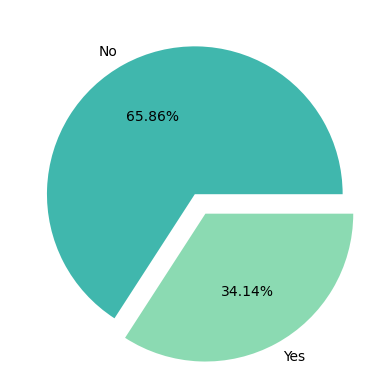

In [33]:
## Pie plot of Any_poi variable
labels = ['No', 'Yes'] 
plt.pie(df['Any_poi'].value_counts(), labels = labels, autopct = '%1.2f%%', labeldistance=1.1, explode=[0, 0.15], colors=(sns.color_palette('mako')[4], sns.color_palette('mako')[5]))
plt.show()

In [34]:
# # Plot frequency of POI
# poi_counts = df[poi].melt()
# poi_counts = pd.crosstab(index=poi_counts['variable'], columns=poi_counts['value'])
# poi_counts['false_freq'] = round((poi_counts[0] / (poi_counts[0] + poi_counts[1]))*100,2)
# poi_counts['true_freq'] = round((poi_counts[1] / (poi_counts[0] + poi_counts[1]))*100,2)
# poi_counts = poi_counts[['false_freq','true_freq']].copy()
# labels = list(poi_counts.index.values)
# ax = poi_counts.plot.barh(stacked=True, cmap=ListedColormap(sns.color_palette('mako')), figsize=(15, 12))
# ax.get_legend().remove()
# for c in ax.containers:
#      ax.bar_label(c, label_type='center', color='#fff')
# plt.legend().remove()
# plt.show()

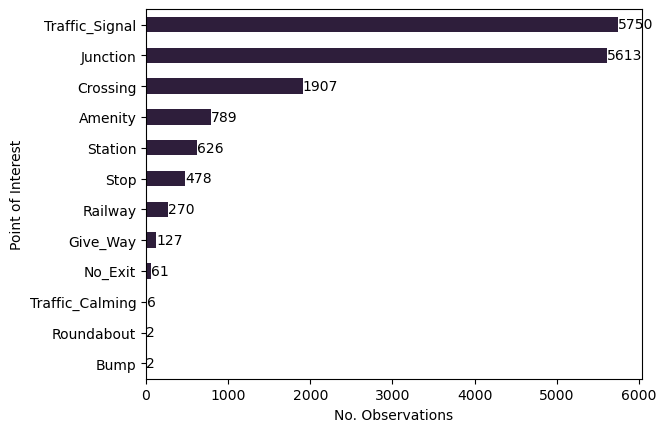

In [35]:
# Plot frequency of POI
poi_counts = df[poi].melt()
poi_counts = pd.crosstab(index=poi_counts['variable'], columns=poi_counts['value'])
poi_counts = poi_counts[1].sort_values(ascending=True)

ax = poi_counts.plot.barh(cmap=ListedColormap(sns.color_palette('mako')))
ax.set(title='', xlabel="No. Observations", ylabel="Point of Interest")
for container in ax.containers:
    ax.bar_label(container, fmt= "%.0f")
plt.show()

In [36]:
# Frequency of Severity by POI
df_poi = pd.DataFrame()
for p in poi:
    melted_df = df.melt(id_vars=['Severity'], value_vars = [p])
    melted_df = pd.crosstab(index=melted_df['Severity'], columns=melted_df['value'])
    df_poi[p] = round((melted_df[1] / melted_df[1].sum())*100,2)

df_poi

,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal
Severity,,,,,,,,,,,,
1,1.65,0.00,1.57,0.79,2.16,0.00,0.74,0.00,0.96,0.84,0.00,1.67
2,73.26,0.00,73.94,70.08,79.55,96.72,75.93,100.00,71.57,75.10,66.67,72.31
3,15.72,0.00,15.36,13.39,12.20,0.00,9.26,0.00,12.62,11.72,0.00,18.14
4,9.38,100.00,9.12,15.75,6.09,3.28,14.07,0.00,14.86,12.34,33.33,7.88


,Temperature,Humidity,Pressure,Visibility,Wind_Speed,Precipitation
Severity,0.10,-0.04,-0.01,-0.00,0.04,0.01


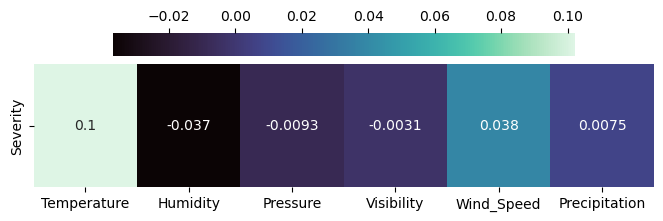

In [37]:
# Correlations
# Find correlations for weather features
cols = ['Severity'] + weather
corr = df[cols].corr()
x = corr[0:1].drop(columns=['Severity'])
display(x)

# Plot correlation to Severity
plt.figure(figsize=(8,2))
sns.heatmap(x, cmap='mako', annot=True, cbar_kws=dict(use_gridspec=False,location="top"))
plt.show()

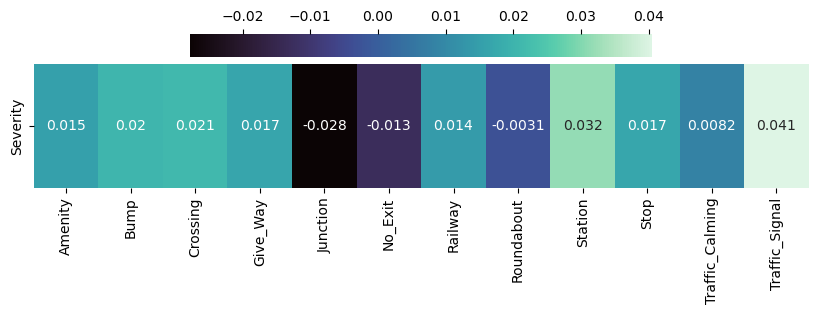

In [38]:
## Find correlations for poi features 
cols = ['Severity'] + poi
corr = df[cols].corr()
x = corr[0:1].drop(columns=['Severity'])

# Plot correlation to Severity
plt.figure(figsize=(10,2))
sns.heatmap(x, cmap='mako', annot=True, cbar_kws=dict(use_gridspec=False,location="top"))
plt.show()

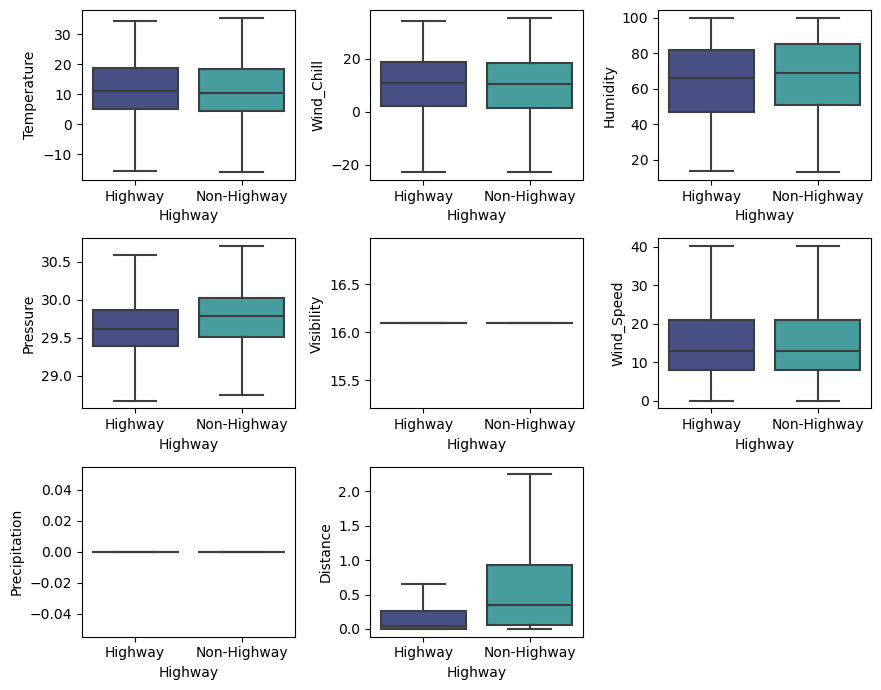

In [39]:
# Frequency of accidents on highways, compared to other road types.
# Boxplot each variable
fig, ax = plt.subplots(3, 3)
fig.set_figheight(7)
fig.set_figwidth(9)
sns.boxplot(ax = ax[0, 0], x='Highway',y='Temperature', data=df, showfliers=False, palette='mako')
sns.boxplot(ax=ax[0, 1], x='Highway',y='Wind_Chill', data=df, showfliers=False, palette='mako')
sns.boxplot(ax= ax[0, 2], x='Highway',y='Humidity', data=df, showfliers=False, palette='mako')
sns.boxplot(ax = ax[1, 0], x='Highway',y='Pressure', data=df, showfliers=False, palette='mako')
sns.boxplot(ax = ax[1, 1], x='Highway',y='Visibility', data=df, showfliers=False, palette='mako')
sns.boxplot(ax = ax[1, 2], x='Highway',y='Wind_Speed', data=df, showfliers=False, palette='mako')
sns.boxplot(ax = ax[2, 0], x='Highway',y='Precipitation', data=df, showfliers=False, palette='mako')
sns.boxplot(ax = ax[2, 1], x='Highway',y='Distance', data=df, showfliers=False, palette='mako')
fig.delaxes(ax[2][2])
plt.setp(ax, xticks=[0, 1], xticklabels=['Highway', 'Non-Highway'])
fig.tight_layout()


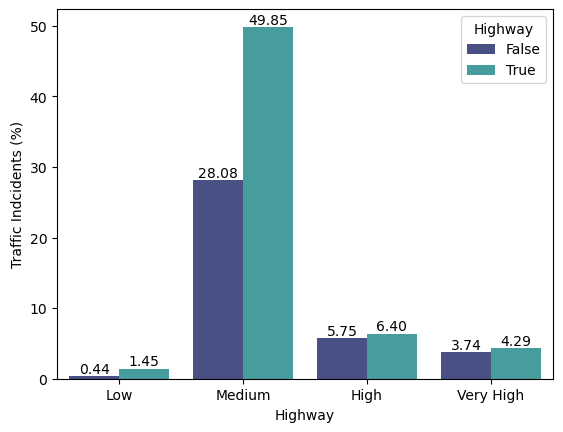

In [40]:
# Accident Severity Frequency by Road Type
ax = sns.barplot(x='Severity', y='Highway', hue='Highway', data=df, estimator=lambda x: len(x) / len(df) * 100 , palette = 'mako')
ax.set(title='', xlabel="Highway", ylabel="Traffic Indcidents (%)")
ax.set_xticklabels(['Low','Medium','High','Very High'])
for container in ax.containers:
    ax.bar_label(container, fmt= "%.2f")
plt.show()

In [41]:
#Bartlett's & ttest means of Weather vs. Road type
cols = ['Distance','Temperature', 'Wind_Chill', 'Humidity', 'Pressure','Visibility','Wind_Speed','Precipitation']  

df_tests = pd.DataFrame(columns=['Variable','chi_sq', 'p-value', 't-test','p-value'])
for column in df[cols]:
    b_stat, b_p = stats.bartlett(df[df['Severity']==1][column], df[df['Severity']==2][column], df[df['Severity']==3][column], df[df['Severity']==4][column])
    t_stat, t_p = stats.ttest_ind(df[column][df['Highway']==True], df[column][df['Highway']==False], equal_var=True)
    df_tests.loc[len(df_tests)] = [column, b_stat, b_p, t_stat, t_p]
    
df_tests

,Variable,chi_sq,p-value,t-test,p-value
0,Distance,"3,441.47",0.00,34.17,0.00
1,Temperature,57.26,0.00,-4.61,0.00
2,Wind_Chill,73.42,0.00,-4.28,0.00
3,Humidity,95.24,0.00,13.03,0.00
4,Pressure,259.88,0.00,28.52,0.00
5,Visibility,30.64,0.00,-14.75,0.00
6,Wind_Speed,8.79,0.03,1.02,0.31
7,Precipitation,688.01,0.00,6.44,0.00


In [42]:
# Summarise Weather by Road Type
df_stats = df.groupby(['Highway']).agg({'Precipitation':{'mean','std'},'Pressure':{'mean','std'},'Visibility':{'mean','std'}, 'Wind_Chill':{'mean','std'}, 'Humidity':{'mean','std'}, 'Temperature':{'mean','std'}, 'Wind_Speed':{'mean','std'}})
df_stats


Precipitation      Pressure      Visibility      Wind_Chill        \
                 mean  std     mean  std       mean  std       mean   std   
Highway                                                                     
False            0.10 0.57    29.62 0.36      14.95 3.86      10.30 10.83   
True             0.15 0.77    29.74 0.40      14.26 4.56       9.81 10.63   

        Humidity       Temperature      Wind_Speed       
            mean   std        mean  std       mean  std  
Highway                                                  
False      64.41 20.80       11.69 9.37      14.54 9.28  
True       67.27 20.28       11.23 9.07      14.64 9.53

In [43]:
df_stats2 = df.groupby(['Highway']).agg({'Distance':{'count','mean','std'}})
df_stats2

Distance            
            mean  std  count
Highway                     
False       0.30 1.05  13981
True        0.87 1.78  22798

In [124]:
# Compare mean of incidents by month
# Calculate mean number of incidents by month
df_month = df.groupby(['Year', 'Month']).size().reset_index(name="Incidents")
month_stats = df_month.groupby(['Month']).agg({'Incidents':{np.mean,np.std}})
month_stats

Incidents         
           mean      std
Month                   
1        258.00   234.76
2        507.50   447.60
3        838.00 1,105.92
4      2,115.00 1,861.11
5      1,940.50 1,706.25
6      2,015.00 1,945.96
7        373.50   518.31
8        286.50   351.43
9      1,524.50 1,552.10
10     2,395.00 2,766.20
11     2,807.00 3,706.65
12     3,329.00 4,231.33

In [95]:
# Compare mean by day of week
# Calculate mean number of incidents by day of week
df_days = df[['Start_Time','Year','Weekday']].copy()
df_days['Week_number'] = df['Start_Time'].dt.isocalendar().week
df_days1 = df_days.groupby(['Year', 'Week_number','Weekday']).size().reset_index(name="Incidents")
days_stats = df_days1.groupby(['Weekday']).agg({'Incidents':{np.mean,np.std}})

days_stats

Incidents      
             mean   std
Weekday                
0           64.81 70.10
1           68.38 71.07
2           64.02 71.09
3           74.70 87.26
4           69.82 76.51
5           42.99 60.77
6           36.12 50.60

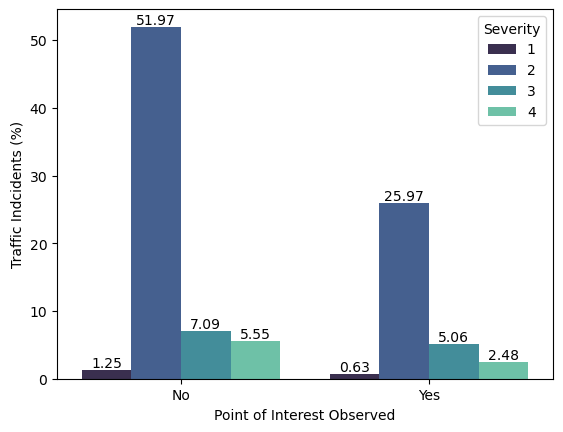

In [45]:
# Presence of a point-of-interest its impact on traffic event  
# Accident Severity Frequency and Points of Interest
ax = sns.barplot(x='Any_poi', y='Severity', hue='Severity', data=df, estimator=lambda x: len(x) / len(df) * 100 , palette = 'mako')
ax.set(title='', xlabel="Point of Interest Observed", ylabel="Traffic Indcidents (%)")
ax.set_xticklabels(['No','Yes'])
for container in ax.containers:
    ax.bar_label(container, fmt= "%.2f")
plt.show()

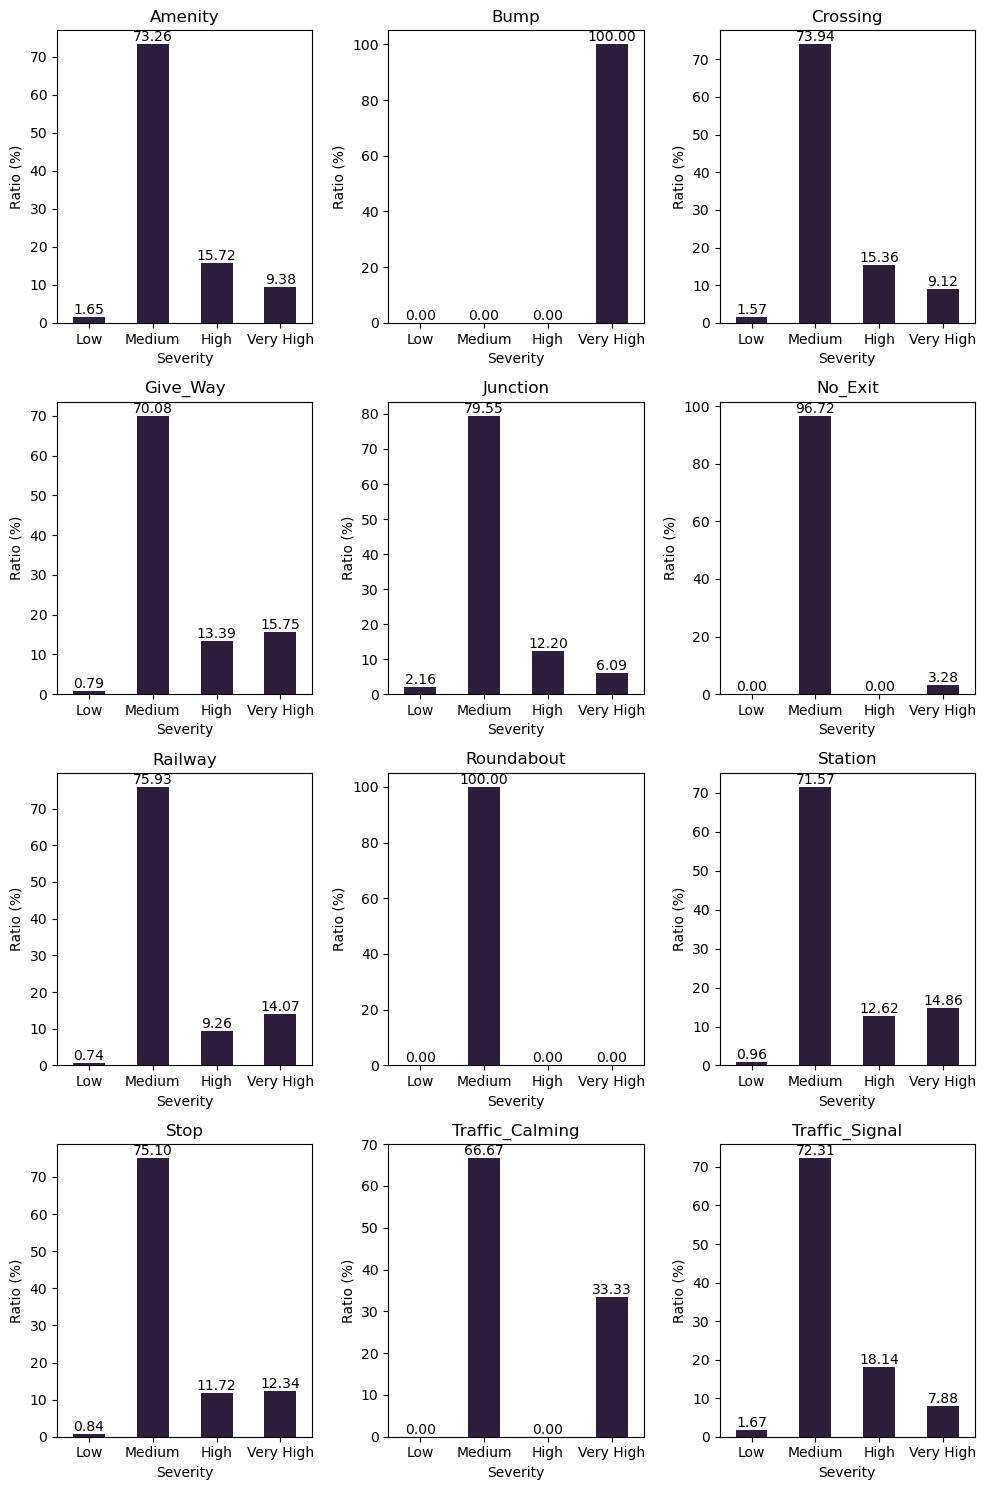

In [46]:
# Barplots of POI by Severity
col = df_poi.columns
counter = 1
fig = plt.figure(figsize=(10,15))
for i in col:
    plt.subplot(4,3,counter)
    ax = df_poi[i].plot(kind='bar', title=i, xlabel='Severity', ylabel='Ratio (%)', rot=0, colormap=ListedColormap(sns.color_palette('mako')))
    ax.set_xticklabels(['Low', 'Medium', 'High', 'Very High'])
    for container in ax.containers:
        ax.bar_label(container, fmt= "%.2f")
    counter += 1
fig.tight_layout()
plt.show()

In [51]:
# Classification modelling to identify which factors most influence accident Severity
# Prepare training and test data
include = ['Start_Lat', 'Start_Lng', 'Distance', 'Temperature', 'Wind_Chill', 'Humidity', 'Pressure', 'Visibility', 'Wind_Speed', 'Precipitation', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Highway', 'Weekday', 'Month', 'Year']
df_feat = df[include].copy()
df_target = df.Severity.copy()

# Normalise the data
cols_to_norm = ['Start_Lat', 'Start_Lng', 'Distance','Temperature', 'Wind_Chill', 'Humidity', 'Pressure', 'Visibility',
       'Wind_Speed', 'Precipitation', 'Weekday', 'Month','Year']
df_feat[cols_to_norm] = df_feat[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(df_feat, df_target, test_size = 0.3, random_state=1)

# Output size of test and training sets
print("Training set size is: ", len(X_train))
print("Test set size is: ", len(X_test))

Training set size is:  25745
Test set size is:  11034


In [ ]:
# Balance training dataset
smo_tek = SMOTETomek(random_state=1)
X_train, y_train = smo_tek.fit_resample(X_train, y_train)

# Create df to store model performance 
results = pd.DataFrame(columns = ['Model','Precision', 'Recall','F1-Score','Accuracy'])

# Output info after balancing
print("Balanced training set size is: ", len(X_train))

df = y_train.value_counts().rename_axis('Severity').reset_index(name='Count')
display(df.sort_values('Severity').style.hide(axis='index'))

In [ ]:
# Supervised Learning with K-Nearest Neghbours
parameters = {'n_neighbors': np.arange(1, 50)}

# Find the best value of n parameters using random search
knn = RandomizedSearchCV(KNeighborsClassifier(), parameters, random_state=1, cv = 5, scoring='f1_weighted')
knn.fit(X_train, y_train)

# Return parameters of model with highest accuracy
optimal_model = knn.best_estimator_
print('Best parameters are: ')
print( knn.best_params_)

n_results = pd.DataFrame(knn.cv_results_)[['params', 'mean_test_score']] # save results of random search

knn_predictions = knn.predict(X_test) # Perform prediction on test data
results.loc[len(results)] = scores('K-Nearest Neighbours (k='+np.array2string(knn.best_params_['n_neighbors'])+')', y_test, knn_predictions) # Store metrics to results df

In [ ]:
# Plot random search performance for different values of k
n_results = pd.DataFrame(knn.cv_results_)[['params', 'mean_test_score']]
n_results['params'] = n_results['params'].apply(pd.Series)
ax = sns.lineplot(x='params', y='mean_test_score', data=n_results)
ax.set(title='', xlabel="N", ylabel="Mean Test Score (%)")
plt.show()

In [ ]:
# Test KNN for optimal k + 3
kparam=knn.best_params_['n_neighbors']+3
KNNClassifier = KNeighborsClassifier(n_neighbors=kparam)
KNNClassifier.fit(X_train, y_train)
knn_predictions = KNNClassifier.predict(X_test)
value = str(kparam)
results.loc[len(results)] = scores('K-Nearest Neighbours (k='+value+')', y_test, knn_predictions) # Store metrics to results df

In [ ]:
# Unsupervised Learning with Random Forest
parameters = {'n_estimators': [500, 1000, 1500, 2000],
               'max_depth': [20, 40, 60, 80, 100],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]}

rf = RandomizedSearchCV(RandomForestClassifier(), parameters, cv = 2, random_state=1, scoring='f1_weighted', verbose = 0)
rf.fit(X_train, y_train)

# Return parameters of model with highest accuracy
optimal_model = rf.best_estimator_
print('Best parameters are: ')
print( rf.best_params_)

rf_predictions = rf.predict(X_test) # Perform prediction on test data

results.loc[len(results)] = scores('Random Forest', y_test, rf_predictions) # Store metrics to results df

# Plot important features
feature_names = df_feat.columns
importances = rf.best_estimator_.feature_importances_

forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=True)

fig, ax = plt.subplots()
forest_importances.plot.barh(ax=ax)
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
# Output results of models
display(results.round(4).style.hide(axis = 'index'))